In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from scipy import ndimage
from typing import List
from sklearn import svm

%matplotlib inline

## Step 1: Find Resistor Box

204 74 851 231


<Figure size 432x288 with 0 Axes>

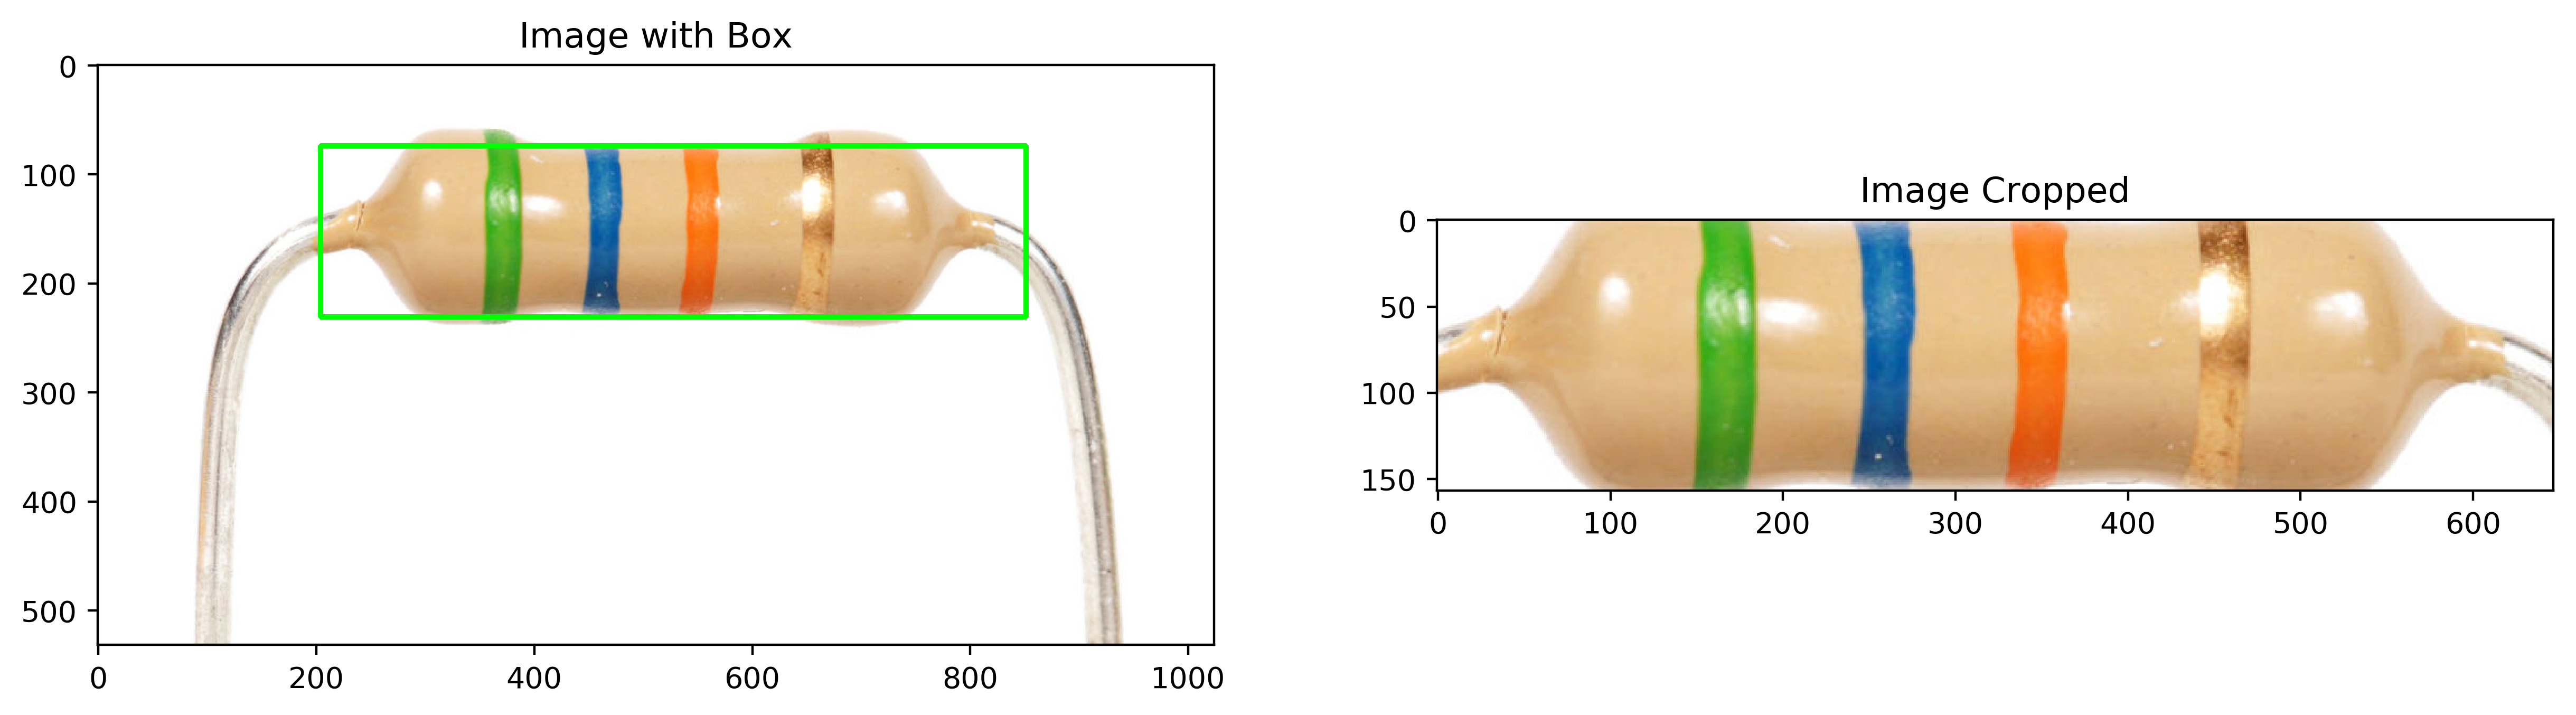

In [9]:
def find_resistor_box(img):
    # convert image to grayscale image
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # convert the grayscale image to binary image
    threshold = 230
    ret, bin_img = cv2.threshold(gray_image,threshold,255,0)
    #plt.imshow(bin_img, cmap='gray')

    # find center of mass
    cy,cx = ndimage.measurements.center_of_mass(bin_img)
    
    cx = int(cx)
    cy = int(cy)
    
    # get dimensions of img
    height = len(bin_img)
    width = len(bin_img[0])
    
    # too big is bad
    streak_size = 10
    
    
    # find vertical boundaries
    y_top = 0
    y_bottom = height
    
    # Top boundary
    while(y_top < height):
        region = bin_img[y_top:(y_top + streak_size), cx]
        consistent_black = True
        
        # Stop if found consistent region of black pixels
        for p in region:
            if(p != 0):
                consistent_black = False
                break
        if(consistent_black):
            break
                         
        y_top += 1
    
    # Bottom boundary
    while(y_bottom > 0):
        region = bin_img[(y_bottom - streak_size):y_bottom, cx]
        consistent_black = True
        
        # Stop if found consistent region of black pixels
        for p in region:
            if(p != 0):
                consistent_black = False
                break
        if(consistent_black):
            break
        
        y_bottom -= 1
    
    
    # Update center y
    center_y = (y_top + y_bottom) // 2
    
        
    # Find horizontal boundaries
    x_left = 0
    x_right = width
    
    # Left boundary
    while(x_left < width):      
        region = bin_img[center_y, x_left:(x_left + streak_size)]
        consistent_black = True
        
        # Stop if found consistent region of black pixels
        for p in region:
            if(p != 0):
                consistent_black = False
                break
        if(consistent_black):
            break
        
        x_left += 1
        
    # Right boundary
    while(x_right > 0):
        region = bin_img[center_y, (x_right - streak_size):x_right]
        consistent_black = True
        
        # Stop if found consistent region of black pixels
        for p in region:
            if(p != 0):
                consistent_black = False
                break
        if(consistent_black):
            break
            
        x_right -= 1

        
        
    # Get top left corner
    x1 = x_left
    y1 = y_top
    
    # Get bottom right corner
    x2 = x_right
    y2 = y_bottom
    
    print(x1, y1, x2, y2)
    
    return x1, y1, x2, y2
        
        
        
# test function
img = cv2.cvtColor(cv2.imread("res.jpg"), cv2.COLOR_BGR2RGB)
x1, y1, x2, y2 = find_resistor_box(img)
img_boxed = np.copy(img)
img_boxed = cv2.rectangle(img_boxed,(x1,y1),(x2,y2),(0,255,0),3)
img_cropped = img[y1:y2, x1:x2]

#plotting figures
fig = plt.figure()
plt.subplots(1, 2, figsize=(15,15), dpi=400)
plt.subplot(1, 2, 1, title="Image with Box")
plt.imshow(img_boxed)

plt.subplot(1, 2, 2, title="Image Cropped")
plt.imshow(img_cropped)

## Step 2: Column Averaging

<Figure size 432x288 with 0 Axes>

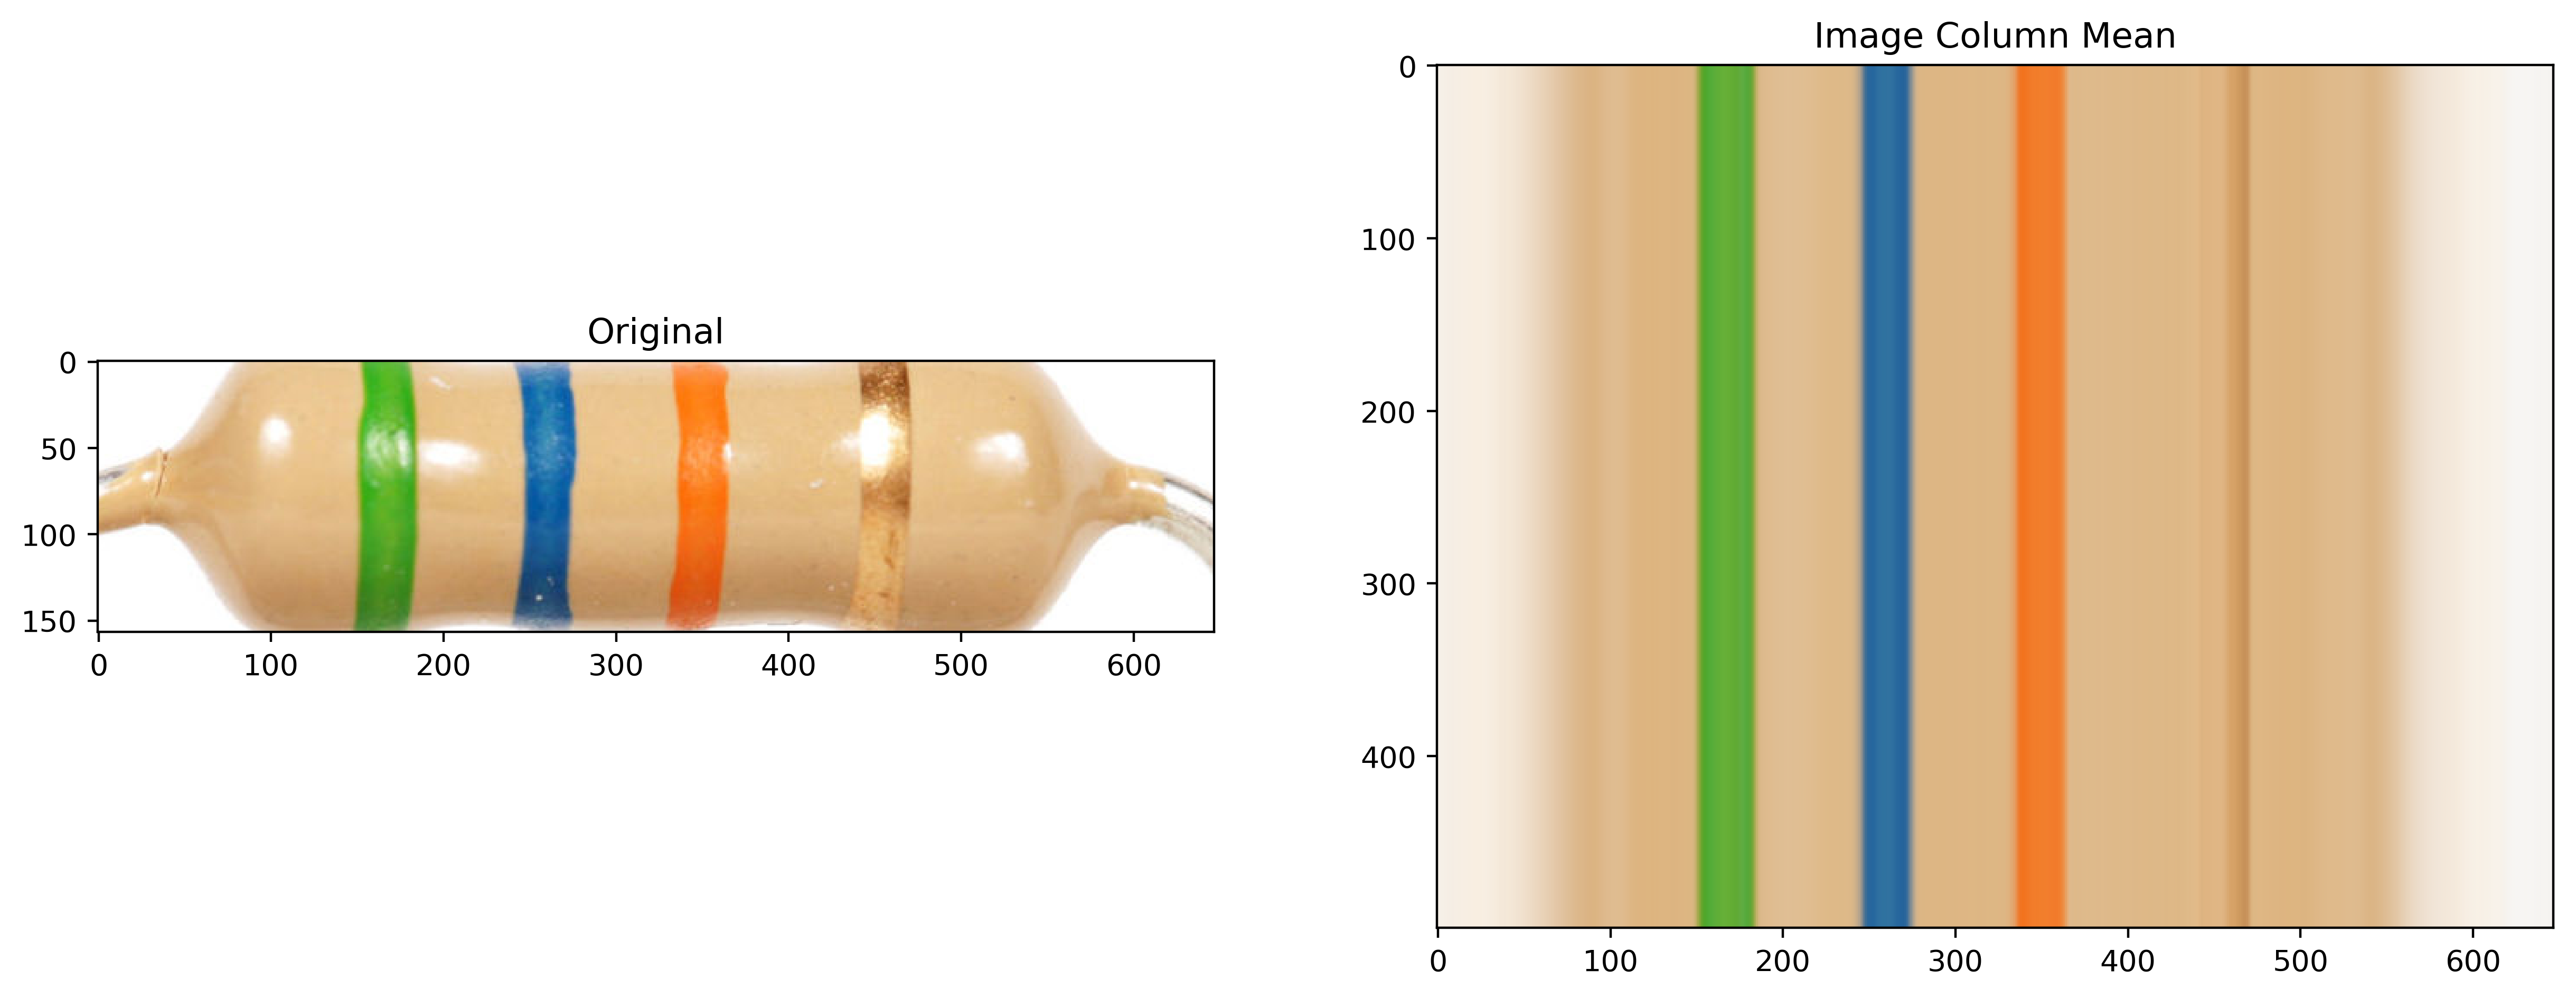

In [11]:
def columnsAvg(img: List[List[List[np.uint8]]]) -> List[List[np.uint8]]:
    image = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    columns = []
    #now take mean across rows (originally columns)
    for col in image:
        avgs = np.array([np.mean(col[:,0]), np.mean(col[:,1]), np.mean(col[:,2])], dtype=np.uint8)
        columns.append(avgs)
    return np.array(columns)

colAvg = columnsAvg(img_cropped)
#predictions = clf.predict(colAvg)

#plotting figures
fig = plt.figure()
plt.subplots(1, 2, figsize=(15,15), dpi=400)
plt.subplot(1, 2, 1, title="Original")
plt.imshow(img_cropped)

plt.subplot(1, 2, 2, title="Image Column Mean")
plt.imshow([colAvg]*500)

## Step 3: Color Prediction

In [16]:
colors = [([255, 0, 0], 'red'), ([255, 64, 0], 'red'), ([255, 0, 64], 'red'), ([210, 45, 45], 'red'), ([255, 102, 102], 'red'), ([250, 114, 144], 'red'), ([246, 91, 103], 'red'), ([246, 40, 103], 'red'), ([182, 14, 17], 'red'), ([164, 35, 3], 'red'),
          ([255, 128, 0], 'orange'), ([250, 100, 0], 'orange'), ([245, 142, 35], 'orange'), ([245, 105, 35], 'orange'), ([245, 144, 35], 'orange'), ([224, 98, 29], 'orange'), ([212, 126, 68], 'orange'), ([217, 116, 57], 'orange'), ([220, 104, 42], 'orange'), ([223, 96, 29], 'orange'), ([226, 93, 23], 'orange'), ([224, 94, 23], 'orange'), ([224, 99, 30], 'orange'), ([223, 101, 33], 'orange'), ([221, 110, 44], 'orange'), ([215, 121, 57], 'orange'),
          ([255, 255, 0], 'yellow'), ([250, 250, 0], 'yellow'), ([250, 254, 144], 'yellow'), ([250, 254, 98], 'yellow'), ([216, 196, 104], 'yellow'), ([216, 198, 93], 'yellow'), ([216, 202, 76], 'yellow'), ([215, 203, 61], 'yellow'), ([217, 206, 66], 'yellow'), ([219, 210, 64], 'yellow'), ([220, 213, 73], 'yellow'), ([223, 215, 72], 'yellow'),
          ([0, 255, 0], 'green'), ([128, 255, 0], 'green'), ([64, 255, 0], 'green'), ([0, 255, 64], 'green'), ([0, 255, 128], 'green'), ([0, 102, 0], 'green'), ([130, 254, 98], 'green'), ([64, 254, 98], 'green'), ([64, 201, 98], 'green'), ([64, 201, 42], 'green'), ([119, 141, 47], 'green'), ([152, 146, 66], 'green'), ([89, 139, 35], 'green'), ([70, 140, 31], 'green'), ([63, 141, 30], 'green'), ([76, 149, 35], 'green'),
          ([0, 0, 255], 'blue'), ([0, 255, 255], 'blue'), ([0, 191, 255], 'blue'), ([0, 128, 255], 'blue'), ([0, 64, 255], 'blue'), ([64, 0, 255], 'blue'), ([75, 96, 116], 'blue'), ([53, 87, 120], 'blue'), ([35, 81, 124], 'blue'), ([36, 80, 126], 'blue'), ([35, 81, 126], 'blue'), ([41, 87, 130], 'blue'), ([43, 90, 131], 'blue'), ([37, 85, 128], 'blue'),
          ([191, 0, 255], 'violet'), ([255, 0, 255], 'violet'), ([255, 0, 191], 'violet'), ([77, 0, 57], 'violet'), ([250, 114, 185], 'violet'), ([250, 114, 234], 'violet'), ([250, 143, 234], 'violet'), ([182, 76, 127], 'violet'), 
          ([153, 102, 0], 'brown'), ([128, 85, 0], 'brown'), ([102, 68, 0], 'brown'),
          ([179, 134, 0], 'beige'), ([211, 160, 102], 'beige'), ([211, 186, 102], 'beige'), ([224, 160, 102], 'beige'), ([197, 160, 102], 'beige'), ([206, 177, 117], 'beige'), ([206, 177, 144], 'beige'), ([250, 192, 144], 'beige'), ([215, 180, 143], 'beige'), ([212, 175, 136], 'beige'), ([211, 170, 130], 'beige'), ([207, 167, 123], 'beige'), ([205, 162, 115], 'beige'), ([201, 157, 107], 'beige'), ([188, 157, 97], 'beige'), ([168, 155, 83], 'beige'), ([119, 108, 88], 'beige'), ([114, 102, 82], 'beige'), ([124, 112, 91], 'beige'), ([131, 119, 98], 'beige'),
          ([0, 0, 0], 'black'), ([26, 26, 26], 'black'), ([51, 51, 51], 'black'),
          ([115, 115, 115], 'gray'), ([89, 89, 89], 'gray'), ([79, 79, 79], 'gray'), ([84, 84, 84], 'gray'), ([87, 87, 87], 'gray'), ([76, 76, 76], 'gray'), ([94, 94, 92], 'gray'),
          ([255, 255, 255], 'white'), ([240,240,240], 'white') 
         ]

res = [[ i for i, j in colors ], 
       [ j for i, j in colors ]]
X = res[0]
y = res[1]

#found this configuration to work best -- it's possible there's a better one, but this actually worked so I'm rollin w/ it
clf = svm.SVC(C=100, gamma=1e-6)
#clf = svm.LinearSVC()
clf.fit(X, y)
#clf.predict([[37, 80, 126]])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
# Color identification
line = colAvg
print(line.shape)

foundColorsSet = set()
foundColorsArray = []


i = 0
batchSize = 1
regionSize = 10
startFlag = False
increment = 1

allColors = clf.predict(line)

while(i + regionSize < len(allColors)):
    # Get current pixel color
    color = allColors[i]
    
    # Check consistent color sequence of region size
    for x in range(i, i + regionSize):
        c = allColors[x]
        
        if(color != c):
            color = None
            break
    
    print(i, color)
    
    # If inconsistent color, then move on
    if(color is None):
        i += increment
        continue
    
    if(color == 'beige'):
        startFlag = True
    
    #change: if hit beige, reset color set since we can hit same color band
    
    if(startFlag and color != 'white' and color != 'beige'):
        if(color not in foundColorsSet):
            foundColorsSet.add(color)
            foundColorsArray.append(color)
    i += increment


print("Colors found:\t", foundColorsArray)


(647, 3)
0 white
1 white
2 white
3 white
4 white
5 white
6 white
7 white
8 white
9 white
10 white
11 white
12 white
13 white
14 white
15 white
16 white
17 white
18 white
19 white
20 white
21 white
22 white
23 white
24 white
25 white
26 white
27 white
28 white
29 white
30 white
31 white
32 white
33 white
34 white
35 white
36 white
37 white
38 white
39 white
40 white
41 white
42 white
43 white
44 white
45 white
46 white
47 white
48 None
49 None
50 None
51 None
52 None
53 None
54 None
55 None
56 None
57 beige
58 beige
59 beige
60 beige
61 beige
62 beige
63 beige
64 beige
65 beige
66 beige
67 beige
68 beige
69 beige
70 beige
71 beige
72 beige
73 beige
74 beige
75 beige
76 beige
77 beige
78 beige
79 beige
80 beige
81 beige
82 beige
83 beige
84 beige
85 beige
86 beige
87 beige
88 beige
89 beige
90 beige
91 beige
92 beige
93 beige
94 beige
95 beige
96 beige
97 beige
98 beige
99 beige
100 beige
101 beige
102 beige
103 beige
104 beige
105 beige
106 beige
107 beige
108 beige
109 beige
110 beige


## Step 4: Calculate Resistance

In [31]:
colorValues = {
    'black': 0,
    'brown': 1,
    'red': 2,
    'orange': 3,
    'yellow': 4,
    'green': 5,
    'blue': 6,
    'purple': 7,
    'gray': 8,
    'white': 9
}

toleranceValues = {
    'brown': 1,
    'red': 2,
    'green': 0.5,
    'blue': 0.25,
    'purple': 0.1,
    'gray': 0.05,
    'gold': 5,
    'silver': 10,
}


print(foundColorsArray)

values = [colorValues[c] for c in foundColorsArray]
print(values)

['green', 'blue', 'orange']
[5, 6, 3]


In [30]:
# Find resistance from array of ordered colors. Includes tolerance.
def findResistance(foundColorsArray):
    # Calculate resistance
    resistance = 0
    values = [colorValues[c] for c in foundColorsArray]
    
    numBands = len(values)

    if(numBands == 3):    
        resistance = (values[0]*10 + values[1]) * (10 ** values[2])
    
    elif(numBands == 4):
        resistance = (values[0]*100 + values[1]*10 + values[2]) * (10 ** values[3])

    
    return resistance

res = findResistance(foundColorsArray)

print("Resistance =", res, "ohms")

Resistance = 56000 ohms
